# Marketing campaign analysis


### Data Description

File database.db is based on framework sqlite3

In [116]:
import pandas as pd
import sqlite3 as sql
import matplotlib as plt
import seaborn as sns
import numpy as np

query = 'SELECT * FROM pl'
con = sql.connect('database.db')
df = pd.read_sql_query(sql = query, con=con)
con.close()

df

,client_id,segment,period,product,pl
0,ZDosW1zUAi,Массовый,p_1,Кредит,9.018067
1,wVRHQ9hzrw,Массовый,p_1,Кредит,18.889585
2,6DZQIaOyL3,Массовый,p_1,Кредит,0.369257
3,jDwO0sMhL2,Массовый,p_1,Кредит,124.315319
4,FXIJUkgjLy,Массовый,p_1,Кредит,41.287831
...,...,...,...,...,...
92604,G8E6dyKT3k,Массовый,p_2,Банковская карта,17.362040
92605,10OPeJCF1l,Массовый,p_2,Банковская карта,1.861434
92606,BMN762bZh5,Верхний,p_2,Банковская карта,78.430698
92607,FcB9pJHGVX,Стандартный,p_2,Банковская карта,16.107313


### Tasks

1) Calculate the average net operating income and the number of customers in each segment by period.<br>
2) Calculate the average net operating income by product and seegment and the number of customers with the product for each segment by period.<br>
3) Estimate the outflow of customers from products in period p_2.<br>
4) Calculate the amount of net operating income raised by each manager during the marketing campaign.<br>
5) Evaluate the effectiveness of a marketing campaign.

In [49]:
# number of unique clients in both periods
df.client_id.nunique()

24992

In [50]:
# number of unique clients in 1st period
df[df['period'] =='p_1'].client_id.nunique()

24463

In [51]:
# number of unique clients in 2nd period
df[df['period'] =='p_2'].client_id.nunique()

24646

In [52]:
# what segments exist
df['segment'].unique()

array(['Массовый', 'Стандартный', 'Верхний'], dtype=object)

In [53]:
# types of banking broducts
df['product'].unique()

array(['Кредит', 'РКО', 'Депозит', 'Эквайринг', 'Банковская карта'],
      dtype=object)

In [54]:
df['period'].unique()

array(['p_1', 'p_2'], dtype=object)

In [55]:
# check missing values
df.isna().sum().sum()

0

In [314]:
# replace titles for products and segments with the following:
products = {'Кредит': 'loan', 
            'РКО': 'settlement and cash services',  
            'Депозит': 'deposit', 
            'Эквайринг': 'acquiring', 
            'Банковская карта': 'banking card'}

segments = {'Массовый': 'mass',
            'Стандартный': 'standart',
            'Верхний': 'upper'}


df['product'].replace(products, inplace=True)
df['segment'].replace(segments, inplace=True)
df.head(5)

,client_id,segment,period,product,pl
0,ZDosW1zUAi,mass,p_1,loan,9.018067
1,wVRHQ9hzrw,mass,p_1,loan,18.889585
2,6DZQIaOyL3,mass,p_1,loan,0.369257
3,jDwO0sMhL2,mass,p_1,loan,124.315319
4,FXIJUkgjLy,mass,p_1,loan,41.287831


### 1. Calculate the average net operating income and the number of customers in each segment by period.

In [315]:
(
    df.groupby(['segment', 'period']).
   agg({'pl': 'mean', 'client_id': 'nunique'}).reset_index().
   rename(columns={'pl': 'avg_pl', 'client_id': 'num_of_unique_clients'}).
   pivot_table(index=['segment'], columns=['period'], values=['avg_pl', 'num_of_unique_clients'])
)

avg_pl            num_of_unique_clients       
period          p_1        p_2                   p_1    p_2
segment                                                    
mass      19.729266  23.273464                 17207  17330
standart  40.282587  46.503397                  6061   6110
upper     79.108293  89.650947                  1195   1206

In [316]:
(
    df.groupby(['segment', 'period']).
   agg({'pl': 'mean', 'client_id': 'count'}).reset_index().
   rename(columns={'pl': 'avg_pl', 'client_id': 'num_of_clients'}).
   pivot_table(index=['segment'], columns=['period'], values=['avg_pl', 'num_of_clients'])
)

avg_pl            num_of_clients       
period          p_1        p_2            p_1    p_2
segment                                             
mass      19.729266  23.273464          29032  35950
standart  40.282587  46.503397          10370  12818
upper     79.108293  89.650947           1995   2444

In [317]:
avg_num_of_clients_by_segment = (
    df.groupby(['segment', 'period', 'client_id']).
    agg({'product': 'nunique'}).reset_index().
    rename(columns={'product': 'products_per_client'}).
    groupby(['segment', 'period']).agg({'products_per_client': 'mean'}).
    round(2).reset_index().
    rename(columns={'products_per_client': 'average_num_of_products_per_client'})
)
avg_num_of_clients_by_segment

,segment,period,average_num_of_products_per_client
0,mass,p_1,1.69
1,mass,p_2,2.07
2,standart,p_1,1.71
3,standart,p_2,2.10
4,upper,p_1,1.67
5,upper,p_2,2.03


<Axes: xlabel='segment'>

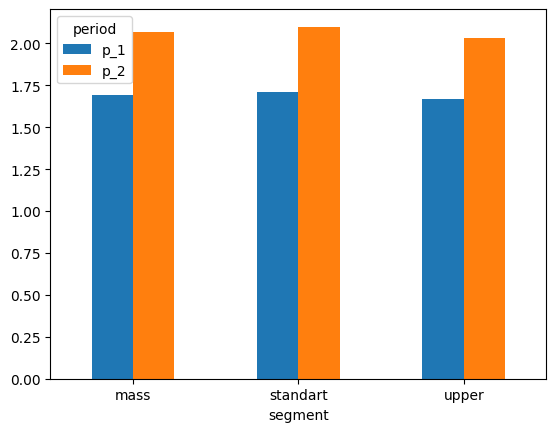

In [318]:
avg_num_of_clients_by_segment.pivot(index='segment', columns='period', values='average_num_of_products_per_client').plot(kind='bar', rot=0)

C:\Users\Anastasia\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


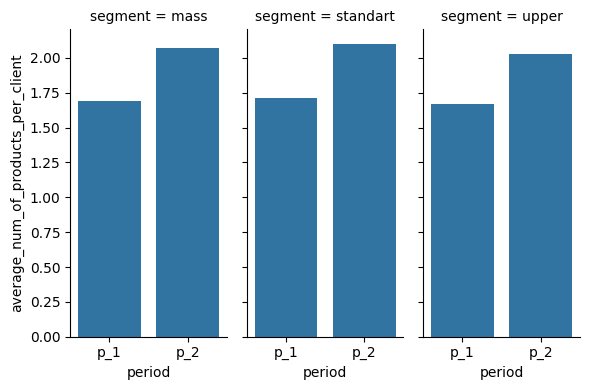

In [319]:
sns.FacetGrid(avg_num_of_clients_by_segment, col="segment", height=4, aspect=.5).\
map(sns.barplot, "period", "average_num_of_products_per_client", order=["p_1", "p_2"])


In [455]:
avg_num_of_clients = (
    df.groupby(['period', 'client_id']).
    agg({'product': 'nunique'}).reset_index().
    rename(columns={'product': 'products_per_client'}).
    groupby(['period']).agg({'products_per_client': 'mean'}).
    round(2).reset_index().
    rename(columns={'products_per_client': 'average_num_of_products_per_client'})
)
avg_num_of_clients

,period,average_num_of_products_per_client
0,p_1,1.69
1,p_2,2.08


In [457]:
df1 = df.groupby(['segment', 'period', 'client_id']).agg({'product': 'nunique'}).reset_index().rename(columns={'product': 'products_per_client'})
df_all_5_products = df1[df1['products_per_client'] == 5].groupby(['segment', 'period']).agg({'client_id': 'count'}).reset_index().\
pivot_table(index=['segment'], columns=['period'], values=['client_id']).rename(columns={'client_id': 'num_of_clients'})
df_all_5_products

num_of_clients    
period              p_1 p_2
segment                    
mass                 10  65
standart              1  33
upper                 2   5

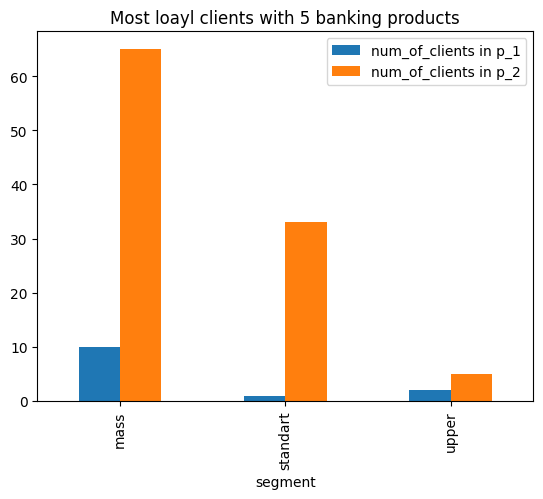

In [466]:
df_all_5_products.plot(kind='bar', title='Most loayl clients with 5 banking products').\
legend(['num_of_clients in p_1', 'num_of_clients in p_2'], title=None)


### 2. Calculate the average net operating income by product and seegment and the number of customers with the product for each segment by period.

In [321]:
df.groupby(['segment', 'period', 'product']).\
   agg({'pl': 'mean', 'client_id': 'nunique'}).reset_index().\
   rename(columns={'pl': 'avg_pl', 'client_id': 'numb_of_clients'}).\
   pivot_table(index=['segment', 'product'], columns=['period'], values=['avg_pl', 'numb_of_clients'])

avg_pl             numb_of_clients  \
period                                        p_1         p_2             p_1   
segment  product                                                                
mass     acquiring                      19.627608   17.348344            2625   
         banking card                   13.310203   11.726557             895   
         deposit                        28.747545   25.219855            3537   
         loan                           59.219407   67.109774            5247   
         settlement and cash services    5.795114    5.566726           16728   
standart acquiring                      39.329551   35.046014             962   
         banking card                   26.421616   22.436106             338   
         deposit                        60.994262   49.332790            1292   
         loan                          120.101219  131.611788            1871   
         settlement and cash services   11.418812   10.983568            5907   
upper    acquiring                      80.517184   72.968866             183   
         banking card                   60.571545   51.770009              49   
         deposit                       112.474520   99.260623             254   
         loan                          236.938710  248.191513             360   
         settlement and cash services   22.847632   22.064079            1149   

                                              
period                                   p_2  
segment  product                              
mass     acquiring                      4424  
         banking card                   2636  
         deposit                        4345  
         loan                           7845  
         settlement and cash services  16700  
standart acquiring                      1590  
         banking card                    917  
         deposit                        1570  
         loan                           2871  
         settlement and cash services   5870  
upper    acquiring                       284  
         banking card                    167  
         deposit                         283  
         loan                            548  
         settlement and cash services   1162

In [322]:
# Calculate the total net operating income by product and seegment and the number of customers with the product for each segment by period.
df.groupby(['segment', 'period', 'product']).\
   agg({'pl': 'sum', 'client_id': 'nunique'}).reset_index().\
   rename(columns={'pl': 'total_pl', 'client_id': 'numb_of_clients'}).\
   pivot_table(index=['segment', 'product'], columns=['period'], values=['total_pl', 'numb_of_clients']).reset_index()

segment                       product numb_of_clients         \
period                                                     p_1    p_2   
0           mass                     acquiring            2625   4424   
1           mass                  banking card             895   2636   
2           mass                       deposit            3537   4345   
3           mass                          loan            5247   7845   
4           mass  settlement and cash services           16728  16700   
5       standart                     acquiring             962   1590   
6       standart                  banking card             338    917   
7       standart                       deposit            1292   1570   
8       standart                          loan            1871   2871   
9       standart  settlement and cash services            5907   5870   
10         upper                     acquiring             183    284   
11         upper                  banking card              49    167   
12         upper                       deposit             254    283   
13         upper                          loan             360    548   
14         upper  settlement and cash services            1149   1162   

             total_pl                 
period            p_1            p_2  
0        51522.470650   76749.072807  
1        11912.631687   30911.203026  
2       101680.067703  109580.268403  
3       310724.231052  526476.177132  
4        96940.659699   92964.322441  
5        37835.028014   55723.162104  
6         8930.506181   20573.908977  
7        78804.586529   77452.480043  
8       224709.381560  377857.442886  
9        67450.919956   64473.542687  
10       14734.644751   20723.157814  
11        2968.005722    8645.591583  
12       28568.528169   28090.756271  
13       85297.935527  136008.949279  
14       26251.929445   25638.459448

In [323]:
total_pl_dynamic = df.groupby(['segment', 'period', 'product']).\
   agg({'pl': 'sum'}).reset_index().\
   rename(columns={'pl': 'total_pl'}).\
   pivot_table(index=['segment', 'product'], columns=['period'], values=['total_pl'])

total_pl_dynamic['total_pl incresaed? Y/N'] = np.where(total_pl_dynamic['total_pl']['p_2'] - total_pl_dynamic['total_pl']['p_1'] > 0, 'Y', 'N')
total_pl_dynamic

total_pl                 \
period                                           p_1            p_2   
segment  product                                                      
mass     acquiring                      51522.470650   76749.072807   
         banking card                   11912.631687   30911.203026   
         deposit                       101680.067703  109580.268403   
         loan                          310724.231052  526476.177132   
         settlement and cash services   96940.659699   92964.322441   
standart acquiring                      37835.028014   55723.162104   
         banking card                    8930.506181   20573.908977   
         deposit                        78804.586529   77452.480043   
         loan                          224709.381560  377857.442886   
         settlement and cash services   67450.919956   64473.542687   
upper    acquiring                      14734.644751   20723.157814   
         banking card                    2968.005722    8645.591583   
         deposit                        28568.528169   28090.756271   
         loan                           85297.935527  136008.949279   
         settlement and cash services   26251.929445   25638.459448   

                                      total_pl incresaed? Y/N  
period                                                         
segment  product                                               
mass     acquiring                                          Y  
         banking card                                       Y  
         deposit                                            Y  
         loan                                               Y  
         settlement and cash services                       N  
standart acquiring                                          Y  
         banking card                                       Y  
         deposit                                            N  
         loan                                               Y  
         settlement and cash services                       N  
upper    acquiring                                          Y  
         banking card                                       Y  
         deposit                                            N  
         loan                                               Y  
         settlement and cash services                       N

### 3. Estimate the outflow of customers from products in period p_2.

In [324]:
# data for p_1 period
df1 = df[df['period'] == 'p_1']

In [325]:
# data for p_2 period
df2 = df[df['period'] == 'p_2']
df2

,client_id,segment,period,product,pl
41397,XHgfHt3boG,mass,p_2,loan,35.244275
41398,sujQEPdgvp,mass,p_2,loan,121.858601
41399,jj7zjaRO9L,mass,p_2,loan,19.444304
41400,FXIJUkgjLy,mass,p_2,loan,2.430823
41401,AmbDMtMnUr,mass,p_2,loan,31.668156
...,...,...,...,...,...
92604,G8E6dyKT3k,mass,p_2,banking card,17.362040
92605,10OPeJCF1l,mass,p_2,banking card,1.861434
92606,BMN762bZh5,upper,p_2,banking card,78.430698
92607,FcB9pJHGVX,standart,p_2,banking card,16.107313


In [326]:
# count new clients in p_2 period, they bought products in p_2, but they had no products in p_1
old_clients = list(df1['client_id'])
df2['new_client 1/0'] = np.where(df2['client_id'].isin(old_clients), 0, 1)

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\910872088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['new_client 1/0'] = np.where(df2['client_id'].isin(old_clients), 0, 1)


In [327]:
f'Number of new clients in p_2: {df2["new_client 1/0"].sum()}'

'Number of new clients in p_2: 1092'

In [328]:
# count clients in p_2 period, they bought products in p_1, but they had no products in p_2
clients2 = list(df2['client_id'])
df1[~df1['client_id'].isin(clients2)].shape[0]

608

In [329]:
f'Churn rate for clients in p_2: {round(df1[~df1["client_id"].isin(clients2)].shape[0]/len(df1)*100, 2)}%'

'Churn rate for clients in p_2: 1.47%'

In [330]:
# churn rate for clients broken down by product
# We consider that churn has occurred if a customer stops using one product, even if the overall number of products for that customer has increased

In [331]:
df3 = df1.merge(df2, how='left', left_on=['client_id', 'product'], right_on=['client_id', 'product'])
df3.head(5)

,client_id,segment_x,period_x,product,pl_x,segment_y,period_y,pl_y,new_client 1/0
0,ZDosW1zUAi,mass,p_1,loan,9.018067,NaN,NaN,NaN,NaN
1,wVRHQ9hzrw,mass,p_1,loan,18.889585,NaN,NaN,NaN,NaN
2,6DZQIaOyL3,mass,p_1,loan,0.369257,NaN,NaN,NaN,NaN
3,jDwO0sMhL2,mass,p_1,loan,124.315319,NaN,NaN,NaN,NaN
4,FXIJUkgjLy,mass,p_1,loan,41.287831,mass,p_2,2.430823,0.0


In [332]:
# check if there are clients who were transferred to another segment in the p_2 period
df3[df3['segment_x'] != df3['segment_y']][~df3['segment_y'].isna()].shape[0]

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\1178252535.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3[df3['segment_x'] != df3['segment_y']][~df3['segment_y'].isna()].shape[0]


0

In [333]:
f"Client's churn rate in p_2 is {round(len(df3[df3['segment_y'].isna()])/len(df3)*100, 2)}%"

"Client's churn rate in p_2 is 31.35%"

In [336]:
products_list = ['loan', 'settlement and cash services', 'deposit', 'acquiring', 'banking card']

for p in products_list:
    print(f"Client's churn rate in p_2 is {round(len(df3[df3['product'] == p][df3['segment_y'].isna()])/len(df3[df3['product'] == p])*100, 2)}% for {p} product with {len(df3[df3['product'] == p])} clients in p_1 period")


Client's churn rate in p_2 is 54.61% for loan product with 7478 clients in p_1 period
Client's churn rate in p_2 is 5.07% for settlement and cash services product with 23784 clients in p_1 period
Client's churn rate in p_2 is 75.23% for deposit product with 5083 clients in p_1 period
Client's churn rate in p_2 is 73.87% for acquiring product with 3770 clients in p_1 period
Client's churn rate in p_2 is 84.17% for banking card product with 1282 clients in p_1 period


C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\3602176933.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Client's churn rate in p_2 is {round(len(df3[df3['product'] == p][df3['segment_y'].isna()])/len(df3[df3['product'] == p])*100, 2)}% for {p} product with {len(df3[df3['product'] == p])} clients in p_1 period")
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\3602176933.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Client's churn rate in p_2 is {round(len(df3[df3['product'] == p][df3['segment_y'].isna()])/len(df3[df3['product'] == p])*100, 2)}% for {p} product with {len(df3[df3['product'] == p])} clients in p_1 period")
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\3602176933.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Client's churn rate in p_2 is {round(len(df3[df3['product'] == p][df3['segment_y'].isna()])/len(df3[df3['produc

In [337]:
# Let's consider how many products the client had in the first period and in the second. 
# if the number of products has decreased, it will be considered an outflow
df_p_1 = df1.groupby('client_id').agg({'product': 'count'}).reset_index().rename(columns={'product': 'number_of_products'})
df_p_2 = df2.groupby('client_id').agg({'product': 'count'}).reset_index().rename(columns={'product': 'number_of_products'})
df_p_1_2 = df_p_1.merge(df_p_2, how='left', left_on=['client_id'], right_on=['client_id'], suffixes=('_1', '_2'))
df_p_1_2['number_of_products_2'] = df_p_1_2['number_of_products_2'].fillna(0)

f"Client's churn rate in p_2 is {round(len(df_p_1_2[df_p_1_2['number_of_products_2']< df_p_1_2['number_of_products_1']])/len(df_p_1_2)*100, 2)}%"

"Client's churn rate in p_2 is 22.2%"

### 4. Calculate the amount of net operating income raised by each manager during the marketing campaign

In [224]:
query = 'SELECT * FROM campaign'
con = sql.connect('database.db')
df4 = pd.read_sql_query(sql = query, con=con)
con.close()

df4.head(5)

,client_id,product,response,manager_id
0,owOyJEIst9,Кредит,Согласие,CM_EiBeeRMhdA
1,HkhuPN1KG7,Кредит,Не обработано менеджером,CM_PzEEav4ic0
2,x1rEdC5fys,Кредит,Согласие,CM_RCwv1r0OHO
3,fx0acVADvj,Кредит,Согласие,CM_nJ7j5pAcMB
4,nDNNydkKQR,Кредит,Согласие,CM_EiBeeRMhdA


In [306]:
df4['product'].unique()

array(['Кредит'], dtype=object)

In [339]:
df4_dict = {'Согласие': 'agree', 
            'Не обработано менеджером': 'not processed by manager', 
            'Недозвон':  "didn't get through", 
            'Перезвонить': 'call back',
            'Отказ': 'refusal'}
df4_product = {'Кредит': 'loan'}
df4['response'].replace(df4_dict, inplace=True)
df4['product'].replace(df4_product, inplace=True)
df4.head(5)

,client_id,product,response,manager_id
0,owOyJEIst9,loan,agree,CM_EiBeeRMhdA
1,HkhuPN1KG7,loan,not processed by manager,CM_PzEEav4ic0
2,x1rEdC5fys,loan,agree,CM_RCwv1r0OHO
3,fx0acVADvj,loan,agree,CM_nJ7j5pAcMB
4,nDNNydkKQR,loan,agree,CM_EiBeeRMhdA


In [355]:
df4['response'].unique()

array(['agree', 'not processed by manager', "didn't get through",
       'call back', 'refusal'], dtype=object)

<Axes: ylabel='response'>

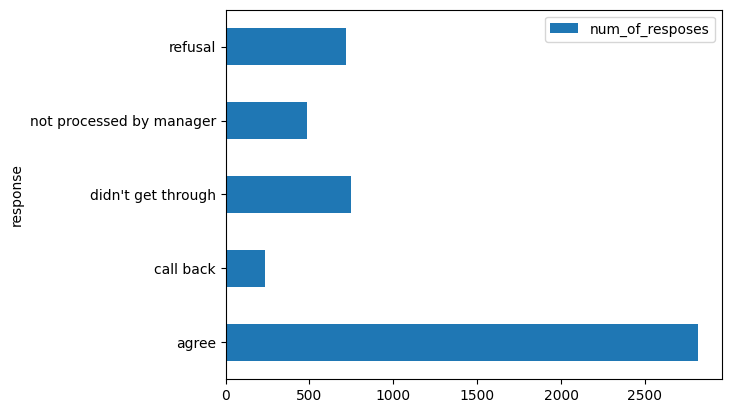

In [341]:
df4.groupby(['response']).agg({'client_id': 'count'}).reset_index().rename(columns={'client_id': 'num_of_resposes'}).plot(kind='barh', x='response')

<Axes: >

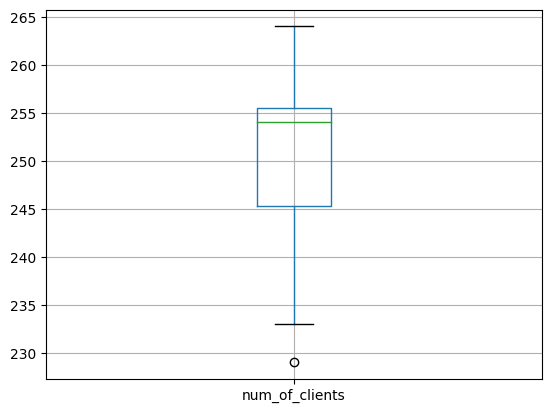

In [342]:
#explore the activity of managers
managers_activity = df4.groupby(['manager_id']).agg({'client_id': 'count'}).reset_index().rename(columns={'client_id': 'num_of_clients'})
managers_activity.boxplot()

In [343]:
managers_activity['num_of_clients'].describe()

count     20.000000
mean     250.000000
std        9.926042
min      229.000000
25%      245.250000
50%      254.000000
75%      255.500000
max      264.000000
Name: num_of_clients, dtype: float64

In [357]:
campaign_sales = df4[df4['response'] == 'agree']

In [358]:
(
    campaign_sales.merge(df2, how='inner', left_on=['client_id', 'product'], right_on=['client_id', 'product']).
    groupby(['manager_id']).
    agg({'pl': 'sum'}).
    reset_index().
    merge(managers_activity, how='inner', left_on=['manager_id'], right_on=['manager_id']).
    sort_values(by=['pl'], ascending=False)
)

,manager_id,pl,num_of_clients
0,CM_2755B4KTu4,16600.098122,261
18,CM_wjb2ArrpAw,14136.285720,257
6,CM_R7BdTh0Svt,14119.009958,246
13,CM_gHP4ykbzTj,14106.604720,248
17,CM_pMFgOhtUKD,13543.156752,254
1,CM_6ofody41cY,13407.509851,263
8,CM_c28lGRRaEI,13358.891157,254
11,CM_eE0WMK1vVW,13298.954882,255
5,CM_PzEEav4ic0,12933.254512,251
4,CM_EiBeeRMhdA,12820.881592,264


### 5. Evaluate the effectiveness of a marketing campaign

In [359]:
# compare sales for 2 periods
total_pl_by_period = df.groupby(['period']).agg({'pl': 'sum'}).reset_index()
total_pl_by_period['pl'] = round(total_pl_by_period['pl'] / 1000, 2)
total_pl_by_period = total_pl_by_period.rename(columns={'pl': 'total_pl_in_mln'})
total_pl_by_period

,period,total_pl_in_mln
0,p_1,1148.33
1,p_2,1651.87


In [360]:
f"Total net operating income increased in p_2 by \
{round((total_pl_by_period['total_pl_in_mln'][1] / total_pl_by_period['total_pl_in_mln'][0] - 1)*100, 2)}%"

'Total net operating income increased in p_2 by 43.85%'

<Axes: title={'center': 'Sales compaign responses'}>

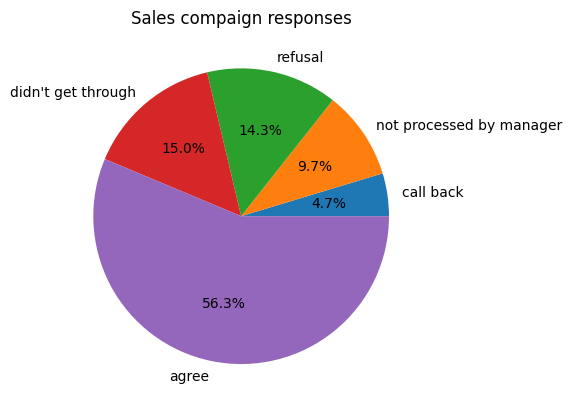

In [399]:
(
    df4.groupby(['response']).
     agg({'manager_id': 'count'}).
     sort_values(by=['manager_id'], ascending=True).
     plot.pie(y='manager_id', autopct="%1.1f%%", legend=False, title='Sales compaign responses', label="", rot=90)
)

In [362]:
f"{df4[df4['response'] == 'agree']['client_id'].count()/df4['client_id'].count()*100}% of clients gave positive response to manager's offer"

"56.32% of clients gave positive response to manager's offer"

In [373]:
positive_response = df4[df4['response'] == 'agree']
df_response_agree = df.merge(positive_response, how='left', right_on='client_id', left_on='client_id')
df_response_agree[~df_response_agree['product_y'].isna()]

,client_id,segment,period,product_x,pl,product_y,response,manager_id
7486,XHgfHt3boG,mass,p_1,settlement and cash services,0.496066,loan,agree,CM_RCwv1r0OHO
7497,faWYjccoeJ,mass,p_1,settlement and cash services,0.084716,loan,agree,CM_6ofody41cY
7519,o63q9tMgDW,standart,p_1,settlement and cash services,6.002074,loan,agree,CM_PzEEav4ic0
7525,GN5jmuNR0V,mass,p_1,settlement and cash services,0.038085,loan,agree,CM_RCwv1r0OHO
7529,cNkUmbtphI,mass,p_1,settlement and cash services,2.380283,loan,agree,CM_9vMKq9aqw9
...,...,...,...,...,...,...,...,...
92592,pvs9tZ1xKV,upper,p_2,banking card,59.801674,loan,agree,CM_c28lGRRaEI
92594,xFyYPhZxgB,mass,p_2,banking card,0.271522,loan,agree,CM_gHP4ykbzTj
92595,rQfRs1CImu,mass,p_2,banking card,11.458721,loan,agree,CM_pMFgOhtUKD
92596,rnu6eQqdG0,mass,p_2,banking card,7.992750,loan,agree,CM_zShYeVNFi0


In [374]:
#check how many clients chose loan product without marketing campaign in second period

In [414]:
clients_in_campaign = list(df4[df4['response'].isin(['agree', 'refusal', 'call back'])]['client_id'])

In [411]:
# number of clients who didn't participate in marketing campaign and didn't have loan product in p_1

In [453]:
df_1_products_by_client = df[df['period'] == 'p_1'].groupby(['segment', 'client_id'])['product'].apply(list).reset_index()
df_2_products_by_client = df[df['period'] == 'p_2'].groupby(['segment', 'client_id'])['product'].apply(list).reset_index()
df_all_products = df_1_products_by_client.\
    merge(df_2_products_by_client, how='left', right_on=['segment', 'client_id'], left_on=['segment', 'client_id'], suffixes=('_1', '_2'))

a = df_all_products[~df_all_products['client_id'].isin(clients_in_campaign)]

a['loan_in_1'] = a['product_1'].str.contains('loan', regex=False)
a['loan_in_2'] = a['product_2'].str.contains('loan', regex=False)
a

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\619213555.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['loan_in_1'] = a['product_1'].str.contains('loan', regex=False)
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_13056\619213555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['loan_in_2'] = a['product_2'].str.contains('loan', regex=False)


,segment,client_id,product_1,product_2,loan_in_1,loan_in_2
0,mass,00AOGn2rc2,[settlement and cash services],[settlement and cash services],False,False
1,mass,00JURPZFUt,"[loan, settlement and cash services]","[settlement and cash services, banking card]",True,False
3,mass,01I0550QBF,[settlement and cash services],[settlement and cash services],False,False
5,mass,01hLVZzHfy,"[settlement and cash services, deposit]","[loan, settlement and cash services]",False,True
6,mass,01zOvj2ido,[acquiring],"[settlement and cash services, acquiring]",False,False
...,...,...,...,...,...,...
24456,upper,zjll2hZeUf,[settlement and cash services],[settlement and cash services],False,False
24457,upper,zns6rOyVJw,[settlement and cash services],"[settlement and cash services, deposit]",False,False
24458,upper,zq0XyHZBPh,[settlement and cash services],"[settlement and cash services, acquiring]",False,False
24459,upper,zrjJeIHI5t,"[loan, settlement and cash services]","[settlement and cash services, acquiring]",True,False


In [452]:
f"{round(a[(a['loan_in_1'] == False) & (a['loan_in_2'] == True)].shape[0] / a.shape[0] * 100, 2)}% of clients \
who didn't take part in marketing campaign took loan in p_2 period vs 56.3% of clients in marketing campaign agreed to take a loan"

"22.64% of clients who didn't take part in marketing campaign took loan in p_2 period vs 56.3% of clients in marketing campaign agreed to take a loan"

### Main conclusions